---
# Twitter Sentiment Analysis of Apple and Google Products for AT&T
---

Flatiron School Phase 4 Project

Analysis by Jun (Andrew) Choi, Peter Vuong, & Nicholas Wertz


<img src="img/AT&T_logo_2016.svg.png" alt="AT&T Logo" width="600"/>

---
# 1. Business Understanding
---
In the ever expanding smartphone market, it is essential to keep up with customer demand. AT&T is deciding on which product brands to offer customers in their physical and online shops and have hired our data science team to help. We have been tasked with investigating the sentiment that customers express online towards differnt product lines to help make a decison on what products should be stocked immediately. We then will use this data to create a model that can predict customers' thoughts on a product so that the client can remain up to date with the product demands of their clientele.

---
# 2. Data Understanding
---
The data set we primarily utilized for our modeling was initially gathered by [data.world from Twitter](https://data.world/crowdflower/brands-and-product-emotions). These tweets were gathered from attendees of Austin's South by Southwest Festival in 2013.

## Importing the Packages/Libraries and Datasets


In [1]:
import pandas as pd
import numpy as np
import re
import string

from matplotlib import pyplot as plt

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer

from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE

Data.world was able to label what products these tweets referred to and labeled whether the emotions expressed were positive, negative, or neutral.


In [2]:
# Initial loading and EDA of data
df = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding='latin-1')
df.drop(index=6, inplace=True)
df.drop_duplicates(inplace=True)
df = df.reset_index(drop=True)
df.head(10)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
7,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
8,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion
9,Excited to meet the @samsungmobileus at #sxsw ...,Android,Positive emotion


We can see that the insial data set has been put into 3 different columns:
- The text contained in the tweet
- The product refered to in the tweet
- The emotion expressed in the tweet

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9070 entries, 0 to 9069
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9070 non-null   object
 1   emotion_in_tweet_is_directed_at                     3282 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9070 non-null   object
dtypes: object(3)
memory usage: 212.7+ KB


However, we can already see that these columns will require a lot of cleaning. Almost all entries in the `tweet_text`  column contain special characters and only 3282 entries have a non-null value in the `emotion_in_tweet_is_directed_at` column. Also, it would be extremely difficult and computationally expensive to correctly identify each product mentioned in tweet due to the sheer number of targets.

---
# 3. Data Preprocessing and EDA
---
We decided the best way to deal with the number of products was to bin them into two caterogies (Apple and Google) based on the product listed. We created the fuction below that performed binning on the inital data, renamed the columns, categorized our target emotion data as numeric values where "Positive emotion" = 0, "Negative emotion" = 1, "No emotion toward brand or product" = 2, and "I can't tell" = 3. The fuction then drops this final "I can't tell" category, as it adds no value to our data analysis.

In [4]:
def df_cleaner(df):
    # Creating two lists to bin the brand/product column
    apple_list = ['iPad', 'Apple', 'iPad or iPhone App', 
                  'Other Apple product or service', 'iPhone']
    google_list = ['Google', 'Other Google product or service', 'Android App', 'Android']
    
    # Binning list comprehension for Apple, Google
    df['emotion_in_tweet_is_directed_at'] = ['Apple' if val in apple_list
                                              else val for val in df['emotion_in_tweet_is_directed_at']]

    df['emotion_in_tweet_is_directed_at'] = ['Google' if val in google_list
                                              else val for val in df['emotion_in_tweet_is_directed_at']]
    
    df['emotion_in_tweet_is_directed_at'] = [val if val == 'Apple' or val == 'Google'
                                          else 'Google' if any(ele.casefold() in df['tweet_text'][ind].casefold() for ele in google_list)
                                          else 'Apple' if any(ele.casefold() in df['tweet_text'][ind].casefold() for ele in apple_list)
                                          else val
                                          for ind, val in df['emotion_in_tweet_is_directed_at'].iteritems()]
    
    # Renaming columns to simplify
    df2 = df.dropna(axis = 0)
    df2 = df2.rename(columns={"emotion_in_tweet_is_directed_at": "product",\
                       "is_there_an_emotion_directed_at_a_brand_or_product":"emotion"})
    
    # Categorizing our target variables
    df2_label = pd.DataFrame(df2['emotion'].copy())
    emotion = df2_label.replace({"emotion": {"Negative emotion" : 1, 
                                    "Positive emotion" : 0, 
                                    "No emotion toward brand or product" : 2,
                                    "I can't tell" : 3}})
    
    # Removing the "I can't tell" targets as it is not needed for our analysis
    df2['emotion'] = emotion
    df2['emotion'] = df2['emotion'].astype('int')
    df2 = df2[df2['emotion'] != 3]
    return df2

We then created a score printer function for our upcoming modeling iterations.

In [5]:
def score_matrix_printer(model, X_train, y_train, X_test, y_test):
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # Need to explicitly declare the average for Multiclass
    avg = 'macro'
    
    # Cleaning up scores to be more visually appealing
    ascore_train = round((accuracy_score(y_train, train_pred) * 100), 2)
    pscore_train = round((precision_score(y_train, train_pred, average=avg) * 100), 2)
    rscore_train = round((recall_score(y_train, train_pred, average=avg) * 100), 2)
    
    ascore_test = round((accuracy_score(y_test, test_pred) * 100), 2)
    pscore_test = round((precision_score(y_test, test_pred, average=avg) * 100), 2)
    rscore_test = round((recall_score(y_test, test_pred, average=avg) * 100), 2)
    
    conf_mat = plot_confusion_matrix(model, X_test, y_test)
    
    print(f"""
    Train Accuracy: {ascore_train}%
    Train Precision: {pscore_train}%
    Train Recall: {rscore_train}%
    ------------------------------
    Test Accuracy: {ascore_test}%
    Test Precision: {pscore_test}%
    Test Recall: {rscore_test}%
    """)

Once we were happy with our data cleaning fuction, we needed to preprocess all text so that natural language processing could be properly be performed. The fuction below takes entered texts, tokenizes each word using a Regex tokenizer, stems words with a more agressive Snowball Stemmer, while simultaneously removing any stopwords, before finally returning the text ready to be used for natural language processing.

In [6]:
def preprocess_text(text):
    additional  = ['rt','rts','retweet']
    pattern = '\s+'
    
    sw = set().union(stopwords.words('english'), additional)
    tokenizer = RegexpTokenizer(pattern, gaps = True)
    stemmer = SnowballStemmer(language = 'english')
    
    token = tokenizer.tokenize(text)
    
    final = [stemmer.stem(word) for word in token if word not in sw]
    
    return " ".join(final)

We created one final custom function that will show out cross validation scores for our final ensemble methods in terms of positve, negative, and neutral scores.

In [7]:
def ensemble_result_printer(model, X_train, y_train, X_test, y_test):
    
    scores = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 5)
    unique, counts = np.unique(model.predict(X_test), return_counts=True)
    result = np.column_stack((unique, counts))
    
    # Cleaning up scores to be more visually appealing
    Pos = "{:.2f}".format((result[0][1] / sum(counts)) * 100)
    Neg = "{:.2f}".format((result[1][1] / sum(counts)) * 100)
    Neut = "{:.2f}".format((result[2][1] / sum(counts)) * 100)

    print(f"""
Ensemble CV Score: {np.median(scores)}
Final Test Accuracy: {accuracy_score(y_test, model.predict(X_test))}
Final Test Precision: {precision_score(y_test, model.predict(X_test), average='macro')}
Final Test Recall: {recall_score(y_test, model.predict(X_test), average='macro')}
----------------------------------------------------
{result}
Positive : {Pos}%
Negative : {Neg}%
Neutral : {Neut}%
""")
    plot_confusion_matrix(model, X_test, y_test);

Next, we used the `df_cleaner` and `preprocess_text` fucntions we created above to prepare our data set for  NLP and modeling.

In [8]:
df2 = df_cleaner(df)

In [9]:
#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",x)
rt = lambda x: re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x)
wspc = lambda x: " ".join(x.split())

df2['tweet_text'] = df2.tweet_text.map(remove_rt).map(rt)
df2['tweet_text'] = df2.tweet_text.str.lower()
df2['tweet_text'] = df2.tweet_text.map(wspc)
df2['tweet_text'] = df2["tweet_text"].map(lambda x : preprocess_text(x))
df2

,tweet_text,product,emotion
0,3g iphon 3 hrs tweet rise austin dead need upg...,Apple,1
1,know awesom ipad iphon app like appreci design...,Apple,0
2,wait ipad 2 also sale sxsw,Apple,0
3,hope year festiv crashi year iphon app sxsw,Apple,1
4,great stuff fri sxsw marissa mayer googl tim r...,Google,0
...,...,...,...
9065,ipad everywher sxsw link,Apple,0
9066,wave buzz interrupt regular schedul sxsw geek ...,Google,2
9067,googl zeiger physician never report potenti ae...,Google,2
9068,verizon iphon custom complain time fell back h...,Apple,2


In [10]:
X = df2['tweet_text']
y = df2['emotion']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [12]:
cv = CountVectorizer()
# Since we're transforming training set, we have to transform test set as well
X_train_vec = cv.fit_transform(X_train)
X_test_vec = cv.transform(X_test)


X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vec)
X_train_vec.columns = sorted(cv.vocabulary_)
X_test_vec = pd.DataFrame.sparse.from_spmatrix(X_test_vec)
X_test_vec.columns = sorted(cv.vocabulary_)
X_test_vec.set_index(y_test.index, inplace=True)
X_train_vec

,00,000,00am,00pm,01am,02,03,08,10,100,...,zip,zite,zms,zombi,zomg,zone,zoom,zuckerberg,zynga,zzzs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6115,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6116,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6117,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6118,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
X_train_vec.sum().sort_values(ascending=False).head()

sxsw     6500
link     2697
googl    1957
ipad     1930
appl     1742
dtype: int64

---
# 4. Modeling
---

## Baseline Model - Multinomial Naieve Bayes Model

In [14]:
# Initialize baseline MultinomialBayes for NLP
mnb = MultinomialNB()
mnb.fit(X_train_vec, y_train)

MultinomialNB()

Training Accuracy: 0.8
Training Recall: 0.6883996700004489
Test Accuracy: 0.6467417932386085
Test Recall: 0.5023168509224286


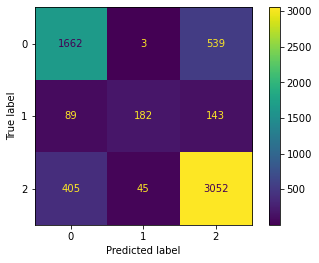

In [15]:
# Creating initial predictions
y_preds = mnb.predict(X_train_vec)
y_test_pred = mnb.predict(X_test_vec)

print("Training Accuracy:", accuracy_score(y_train, y_preds))
print("Training Recall:", recall_score(y_train, y_preds, average = 'macro'))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test Recall:", recall_score(y_test, y_test_pred, average = 'macro'))

cm = confusion_matrix(y_train, y_preds)
cmdisplay = ConfusionMatrixDisplay(cm)
cmdisplay.plot();

## Model 1 -  Pipeline Model for Multinomial Bayes & SMOTE


    Train Accuracy: 78.38%
    Train Precision: 70.28%
    Train Recall: 75.93%
    ------------------------------
    Test Accuracy: 62.91%
    Test Precision: 54.16%
    Test Recall: 56.6%
    


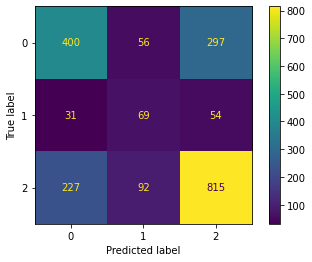

In [16]:
# Pipeline model for Multinomial Bayes + SMOTE
mnb_cv = imbpipeline(steps=[
    ('vectorizer', CountVectorizer()),
    ('SMOTE', SMOTE(sampling_strategy = 'minority', random_state = 42)),
    ('mnb', MultinomialNB())
])

mnb_cv.fit(X_train, y_train)
score_matrix_printer(mnb_cv, X_train, y_train, X_test, y_test)

## Model 2 -  Pipeline Model to Test TFIDF Vectorizer


    Train Accuracy: 76.39%
    Train Precision: 69.54%
    Train Recall: 82.3%
    ------------------------------
    Test Accuracy: 59.82%
    Test Precision: 54.02%
    Test Recall: 62.14%
    


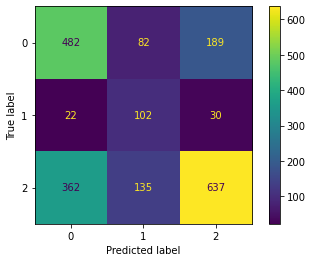

In [17]:
# Pipeline model to test if TfidfVectorizer is better than CountVectorizer
mnb_tfidf = imbpipeline(steps=[
    ('vectorizer', TfidfVectorizer(lowercase = False)),
    ('SMOTE', SMOTE(random_state = 42)),
    ('mnb', MultinomialNB())
])

mnb_tfidf.fit(X_train, y_train)
score_matrix_printer(mnb_tfidf, X_train, y_train, X_test, y_test)

## Model 2.5 - TFIDF Vectorizer with `max_features` = 1500


    Train Accuracy: 68.27%
    Train Precision: 61.44%
    Train Recall: 74.25%
    ------------------------------
    Test Accuracy: 57.52%
    Test Precision: 51.46%
    Test Recall: 58.64%
    


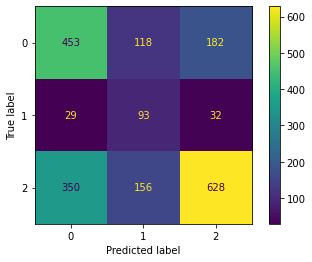

In [18]:
# Pipeline model to test if TfidfVectorizer is better than CountVectorizer
mnb_tfidf_mf = imbpipeline(steps=[
    ('vectorizer', TfidfVectorizer(lowercase = False, max_features=1500)),
    ('SMOTE', SMOTE(random_state = 42)),
    ('mnb', MultinomialNB())
])

mnb_tfidf_mf.fit(X_train, y_train)
score_matrix_printer(mnb_tfidf_mf, X_train, y_train, X_test, y_test)

## Model 3 - Pipeline Model with a Random Forest Classifier


    Train Accuracy: 95.36%
    Train Precision: 94.7%
    Train Recall: 95.38%
    ------------------------------
    Test Accuracy: 58.35%
    Test Precision: 50.15%
    Test Recall: 53.31%
    


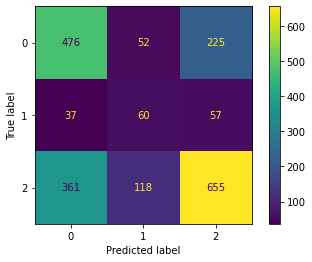

In [19]:
rf_cv = imbpipeline(steps=[
    ('vectorizer', CountVectorizer()),
    ('smote', SMOTE(random_state = 42)),
    ('rf', RandomForestClassifier(random_state = 42))

])

rf_cv.fit(X_train, y_train)
score_matrix_printer(rf_cv, X_train, y_train, X_test, y_test)

## ## Model 3.5 -  Random Forest Clasifier with Vectorizer `max_features` = 1500


    Train Accuracy: 95.49%
    Train Precision: 95.39%
    Train Recall: 95.49%
    ------------------------------
    Test Accuracy: 64.53%
    Test Precision: 62.81%
    Test Recall: 52.37%
    


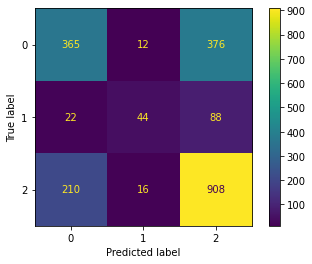

In [20]:
rf_model_max = imbpipeline(steps=[
    ('vectorizer', TfidfVectorizer(lowercase = False, max_features=1500)),
    ('smote', SMOTE(random_state = 42)),
    ('rf', RandomForestClassifier(random_state = 42))

])

rf_model_max.fit(X_train, y_train)
score_matrix_printer(rf_model_max, X_train, y_train, X_test, y_test)

## Using `GridSerachCV` to Optimize Model Parameters

In [21]:
# #Code block has been commented out as it takes over 10 minutes to run.

# X_train_grid, X_test_grid, y_train_grid, y_test_grid = train_test_split(text_series, y, random_state=42)

# rf_basic_cv = imbpipeline(steps=[
#     ('preprocess', TfidfVectorizer(lowercase = False)),
#     ('SMOTE', SMOTE(sampling_strategy = 'minority', random_state = 42)),
#     ('rf', RandomForestClassifier(random_state=42))
# ])


# param_grid = {
#     "preprocess__max_features":[500, 1000, 1500],
#     "rf__n_estimators":[30, 100, 150, 200],
#     "rf__criterion":['gini', 'entropy'], 
#     "rf__max_depth":[1, 10, 25, 50],
#     "rf__min_samples_split":range(1, 10),
#     "rf__min_samples_leaf":range(1, 10)
# }            


# grid = GridSearchCV(rf_basic_cv, param_grid, cv = 5, n_jobs = -1, verbose = 1)
# grid.fit(X_train_grid, y_train_grid)   

In [22]:
# print('Best score and parameter combination = ')

# print(grid.best_score_)    
# print(grid.best_params_)      

From the `GridSearchCV` above, we determined the optimal parameters for `TfidfVectorizer` and `RandomForestClassifier`. We tested these optimized pamameters in the next model.


## Model 4 - Random Forest Classifier with Optimized Parameters


    Train Accuracy: 91.85%
    Train Precision: 93.46%
    Train Recall: 89.74%
    ------------------------------
    Test Accuracy: 63.99%
    Test Precision: 59.41%
    Test Recall: 51.6%
    


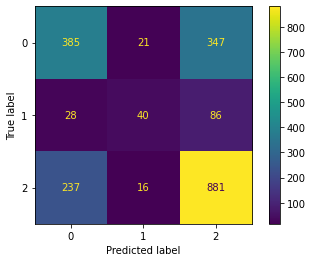

In [23]:
rf_optimal_cv = imbpipeline(steps=[
    ('vectorizer', TfidfVectorizer(lowercase = False, max_features=1500)),
    ('smote', SMOTE(random_state = 42)),
    ('rf', RandomForestClassifier(criterion = 'gini', n_estimators = 150,  max_depth = 50, 
                                  min_samples_leaf = 1, min_samples_split = 5, random_state = 42))

])

rf_optimal_cv.fit(X_train, y_train)
score_matrix_printer(rf_optimal_cv, X_train, y_train, X_test, y_test)

## Model 5 - Ensemble Model Using All Data 


Ensemble CV Score: 0.6413398692810458
Final Test Accuracy: 0.6398824105830475
Final Test Precision: 0.5940866844976433
Final Test Recall: 0.51597479463792
----------------------------------------------------
[[   0  650]
 [   1   77]
 [   2 1314]]
Positive : 31.85%
Negative : 3.77%
Neutral : 64.38%



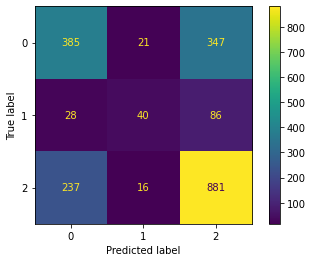

In [24]:
avg = VotingClassifier(estimators=[ ('rf', rf_optimal_cv),
                                    ('mb', mnb_tfidf_mf)],
                                    weights = [0.75, 0.25])

avg.fit(X_train, y_train)

ensemble_result_printer(avg, X_train, y_train, X_test, y_test)

From these results we decided to split the data into two different sets based on the company that produced the products being mentioned to see if it was possible to improve the scores further.

In [25]:
apple = df2.loc[df2['product'] == 'Apple']
google = df2.loc[df2['product'] == 'Google']

a_X = apple['tweet_text']
a_y = apple['emotion']

g_X = google['tweet_text']
g_y = google['emotion']

In [26]:
a_X_train, a_X_test, a_y_train, a_y_test = train_test_split(a_X, a_y, random_state=42)

g_X_train, g_X_test, g_y_train, g_y_test = train_test_split(g_X, g_y, random_state=42)

## Ensemble Model - Apple Data 


Ensemble CV Score: 0.6175349428208387
Final Test Accuracy: 0.6295731707317073
Final Test Precision: 0.5948644708046777
Final Test Recall: 0.5356985016751061
----------------------------------------------------
[[  0 458]
 [  1  69]
 [  2 785]]
Positive : 34.91%
Negative : 5.26%
Neutral : 59.83%



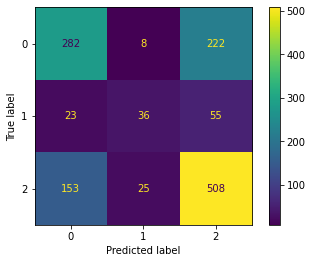

In [27]:
avg = VotingClassifier(estimators=[ ('rf', rf_optimal_cv),
                                    ('mb', mnb_tfidf_mf)],
                                    weights = [0.75, 0.25])

avg.fit(a_X_train, a_y_train)

ensemble_result_printer(avg, a_X_train, a_y_train, a_X_test, a_y_test)

## Ensemble Model - Google Data 


Ensemble CV Score: 0.7276887871853547
Final Test Accuracy: 0.6899862825788752
Final Test Precision: 0.602046783625731
Final Test Recall: 0.4935871377944549
----------------------------------------------------
[[  0 140]
 [  1  19]
 [  2 570]]
Positive : 19.20%
Negative : 2.61%
Neutral : 78.19%



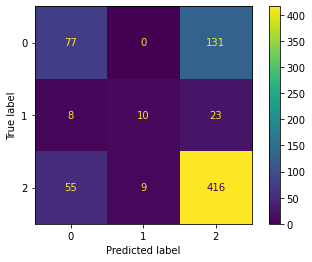

In [28]:
avg = VotingClassifier(estimators=[ ('rf', rf_optimal_cv),
                                    ('mb', mnb_tfidf_mf)],
                                    weights = [0.75, 0.25])

avg.fit(g_X_train, g_y_train)

ensemble_result_printer(avg, g_X_train, g_y_train, g_X_test, g_y_test)

---
# 5. Evaluation
---

---
# 6. Appendix
---

The below code was used to create a wordcloud for our presentation.

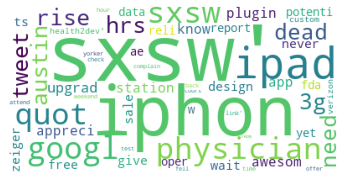

In [29]:
from wordcloud import WordCloud

text = X.values 

wordcloud = WordCloud(background_color = 'white').generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [30]:
# wordcloud.to_file("img/apple_google_wordcloud.png")  #Saves the wordcloud image as a .png file